In [1]:
!pip install pyforest
from pyforest import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import datetime, pickle, copy, warnings
from pandas import DataFrame, concat
import seaborn
import glob
import pandas.testing as tm
from functools import reduce
from pandas import DataFrame, merge, concat
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Parallel, delayed
import seaborn as sns
import time
from sklearn.preprocessing import MaxAbsScaler
import scipy.linalg
import decimal
!pip install scikit-plot
import scikitplot
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.ticker as mtick
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport
from sklearn.decomposition import PCA, KernelPCA
from numpy import where, meshgrid, arange, hstack
from mlxtend.plotting import plot_decision_regions
from sklearn.manifold import TSNE
from sklearn.decomposition import MiniBatchDictionaryLearning
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedStratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV,SelectPercentile,mutual_info_classif, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from numpy import mean, std
!pip install tscv
!pip install termcolor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_csv("july_futures_1min.csv")
df.set_index('timestamp', inplace=True)
df.sort_index(ascending=True, inplace=True)
df.index = pd.to_datetime(df.index)

ts = df.copy()

ts = df[['es_close', 'es_open', 'es_high', 'es_low', 'es_countp', 'es_countg']].copy()
ts.loc[:,'volume'] = ts['es_countp'] + ts['es_countg']
ts = ts[['es_close', 'es_open', 'es_high', 'es_low', 'volume']]
ts = ts[ts['volume'] > 0]
#d = d.reset_index()
ts.index = pd.to_datetime(ts.index) # setting index as datetime
ts = ts.resample('15min').mean() # resampling with 15 min frequency
ts.sort_index(ascending=True, inplace=True) # soring ascending order
ts.drop_duplicates(inplace=True) # dropping duplicates if any
ts.fillna(method='pad', inplace=True) # filling NaN values using bcak-fill method
#print(ts)

# Create the new lagged DataFrame
features = pd.DataFrame(index=ts.index)
features["current_period"] = ts["es_close"].copy()
features["Volume"] = ts["volume"].copy()
#features['o-c'] = (ts['es_open'] - ts['es_close']).copy()
#features['h-l'] = (ts['es_high'] - ts['es_low']).copy()
    
lags = 5
# Create the shifted lag series of prior trading period close values
for i in range(0, lags):
    features["Lag%s" % str(i+1)] = ts["es_close"].shift(i+1)
        
# Create the returns DataFrame
tsret = DataFrame(index=features.index)
tsret["volume"] = features["Volume"]
tsret["current_period"] = features["current_period"].pct_change()*100.0
#tsret['o-c'] = features['o-c'].copy()
#tsret['h-l'] = features['h-l'].copy()
    
# If any of the values of percentage returns equal zero, setting them to
# a small number (stops issues with QDA model)
for i,x in enumerate(tsret["current_period"]):
    if (abs(x) < 0.0001):
        tsret["current_period"][i] = 0.0001
            
# Create the lagged percentage returns columns
for i in range(0, lags):
    tsret["Lag%s" % str(i+1)] = features["Lag%s" % str(i+1)].pct_change()*100.0
# Create the "Direction" column (+1 or -1) indicating an up/down day
tsret["Direction"] = np.sign(tsret["current_period"])

SPret = tsret.dropna().copy()
    # Use the prior two days of returns as predictor
    # values, with direction as the response
x = SPret[["Lag1","Lag2"]]
y = SPret["Direction"]

"""
predictor is set to use only the first two lags. so, 
implicitly stating to the classifier that the further lags are of less predictive value
"""
    
# # Create training and test sets
from tscv import GapKFold
gkcv = GapKFold(n_splits=3, gap_before=2, gap_after=1)

"""
Introduced gaps between the training and test set to mitigate the temporal dependence.
Here the split function splits the data into Kfolds. 
The test sets are untouched, while the training sets get the gaps removed
"""

for tr_index, te_index in gkcv.split(x, y):
    xTrain, xTest = x.values[tr_index], x.values[te_index];
    yTrain, yTest = y.values[tr_index], y.values[te_index];
        #splits.append(('TRAIN:', x_tr, 'TEST:', x_te))
    
#print('Observations: %d' % (len(xTrain) + len(xTest)))
#print('Training Observations: %d' % (len(xTrain)))
#print('Testing Observations: %d' % (len(xTest))) 

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Create the (parametrised) models
print("Hit Rates/Confusion Matrices:\n")
models = [("LR", LogisticRegression()),
          ("LDA", LinearDiscriminantAnalysis()),
          ("QDA", QuadraticDiscriminantAnalysis()),
          ("LSVC", LinearSVC()),
          ("RSVM", SVC(C=1000000.0, cache_size=200, class_weight=None,
                       coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
                       max_iter=-1, probability=False, random_state=None,
                       shrinking=True, tol=0.001, verbose=False)),
          ("RF", RandomForestClassifier(
              n_estimators=1000, criterion='gini',
              max_depth=None, min_samples_split=2,
              min_samples_leaf=1, max_features='auto',
              bootstrap=True, oob_score=False, n_jobs=1,
              random_state=None, verbose=0))]
# iterate over the models
for m in models:
    # Train each of the models on the training set
    m[1].fit(xTrain, yTrain)
    # array of predictions on the test set
    pred = m[1].predict(xTest)
    # hit-rate and the confusion matrix for each model
    print("%s:\n%0.3f" % (m[0], m[1].score(xTest, yTest)))
    print("%s\n" % confusion_matrix(pred, yTest))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hit Rates/Confusion Matrices:

LR:
0.583
[[125  76]
 [207 271]]

LDA:
0.595
[[147  90]
 [185 257]]

QDA:
0.552
[[116  88]
 [216 259]]

LSVC:
0.592
[[145  90]
 [187 257]]

RSVM:
0.589
[[143  90]
 [189 257]]

RF:
0.529
[[159 147]
 [173 200]]



In [3]:
lda = LinearDiscriminantAnalysis().fit(x,y)
SPret['Predicted_Signal'] = lda.predict(x)
ts = ts[['es_close']].copy()
SPret['Close'] = ts.es_close
SPret = SPret[['Close', 'Direction']]
SPret['SP_Returns'] = (np.log(SPret['Close'] / SPret['Close'].shift(1))).copy()

<IPython.core.display.Javascript object>

@sarit:

ValueatRisk (VaR): $2182.65


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sharpe ratio: 2.0181817445987145


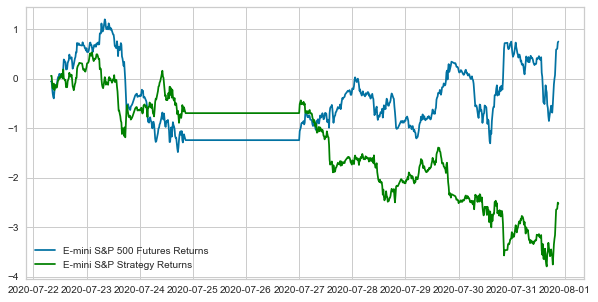

In [6]:
SPret['Predicted_Signal'] = lda.predict(x)
from __future__ import print_function
import datetime
import numpy as np
from scipy.stats import norm

print('@sarit:'); print()
def var_cov_var(P, c, mu, sigma):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

if __name__ == "__main__":
    #SPret["rets"] = SPret["Close"].pct_change()
    P = 1e6 # 1,000,000 USD
    c = 0.99 # 99% confidence interval
    mu = np.mean(SPret["SP_Returns"])
    sigma = np.std(SPret["SP_Returns"])
    var = var_cov_var(P, c, mu, sigma)
    print("ValueatRisk (VaR): $%0.2f" % var); 

def calculate_return(SPret, split_value, symbol):
    cum_return = SPret[split_value:]['%s_Returns' % symbol].cumsum() * 100
    SPret['Strategy_Returns'] = (SPret['%s_Returns' % symbol] * SPret['Predicted_Signal'].shift(1)).copy()
    return cum_return

def calculate_strategy_return(SPret, split_value, symbol):
    cum_strategy_return = SPret[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_return = calculate_return(SPret, split_value = len(xTrain), symbol='SP')
cum_strategy_return = calculate_strategy_return(SPret, split_value = len(xTrain), symbol='SP')

def plot_chart(cum_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='E-mini S&P Strategy Returns', color = 'green')
    plt.legend()
    
plot_chart(cum_return, cum_strategy_return, symbol='E-mini S&P 500 Futures')

def sharpe_ratio(symbol_returns, strategy_returns):
    strategy_std = strategy_returns.std()
    sharpe = (strategy_returns - symbol_returns) / strategy_std
    return sharpe.mean()

print("Sharpe ratio:",sharpe_ratio(cum_strategy_return, cum_return));


@Sarit:
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

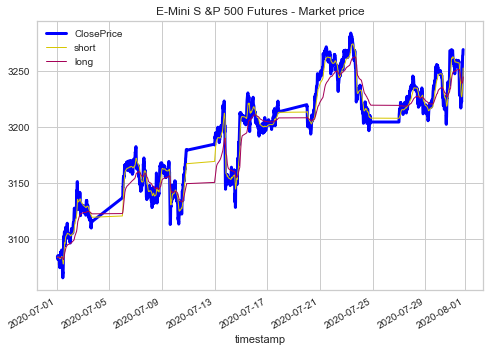

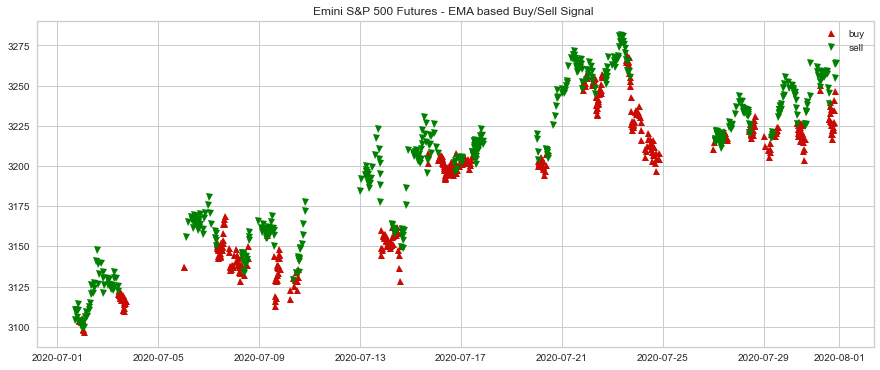

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

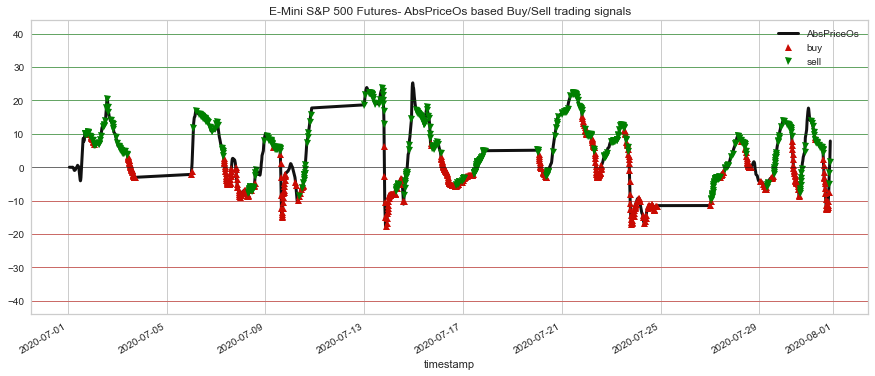

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

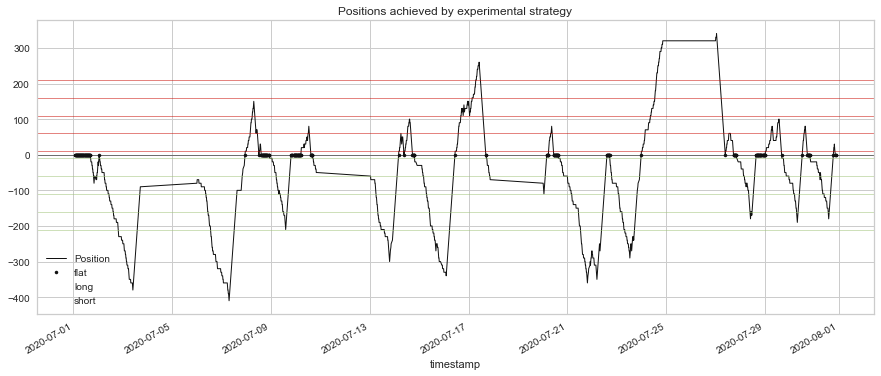

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

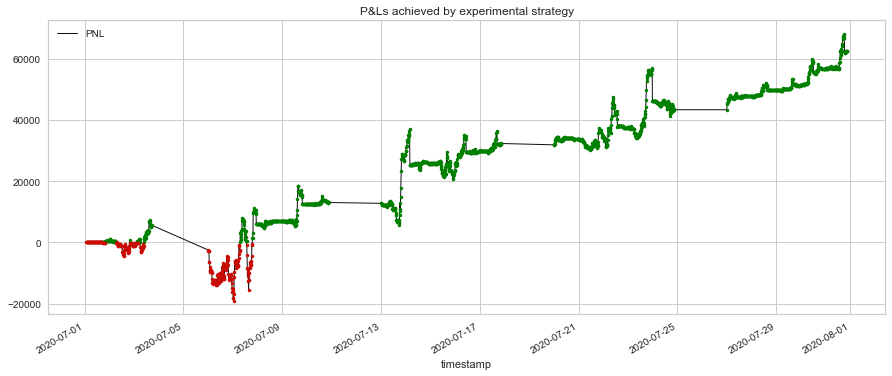

In [10]:
import statistics as stats
import math as math

print("@Sarit:")
# Variables/constants for EMA Calculation:
fast_period = 10 # Static time period parameter for the fast EMA
smooth_fast = 2 / (fast_period + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

slow_period = 40 # Static time period parameter for slow EMA
smooth_slow = 2 / (slow_period + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
apo_buy_enter = -10 # APO trading signal value below which to enter buy-orders/long-position
apo_sell_enter = 10 # APO trading signal value above which to enter sell-orders/short-position
min_price_movement_from_last_trade = 10 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
num_stocks_per_trade = 10 # Number of shares to buy/sell on every trade
min_profit_to_close = 10 * num_stocks_per_trade # Minimum Open/Unrealized profit at which to close positions and lock profits

# Constants/variables that are used to compute standard deviation as a volatility measure
ma_periods = 20 # look back period
price_history = [] # history of prices

close = SPret['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > ma_periods: # we track at most 'time_period' number of prices
        del (price_history[0])

    sma = stats.mean(price_history)
    variance = 0 # variance is square of standard deviation
    for hist_price in price_history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(price_history))
    stdev_factor = stdev/15
    if stdev_factor == 0:
        stdev_factor = 1

    # This section updates fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * smooth_fast * stdev_factor + ema_fast
        ema_slow = (close_price - ema_slow) * smooth_slow * stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
    if ((apo > apo_sell_enter * stdev_factor and abs(close_price - last_sell_price) > min_price_movement_from_last_trade * stdev_factor) 
        # APO above sell entry threshold, we should sell
        or
        (position > 0 and (apo >= 0 or open_pnl > min_profit_to_close / stdev_factor))): # long from -ve APO and APO has gone positive or position is profitable, sell to close position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= num_stocks_per_trade # reduce position by the size of this trade
        sell_sum_price_qty += (close_price * num_stocks_per_trade) # update vwap sell-price
        sell_sum_qty += num_stocks_per_trade
        print( "SELL ", num_stocks_per_trade, " @ ", close_price, "Position => ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
    elif ((apo < apo_buy_enter * stdev_factor and abs(close_price - last_buy_price) > \
           min_price_movement_from_last_trade * stdev_factor) # APO below buy entry threshold, we should buy
          or
          (position < 0 and (apo <= 0 or open_pnl > min_profit_to_close / stdev_factor))): # short from +ve APO and APO has gone negative or position is profitable, buy to close position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += num_stocks_per_trade # increase position by the size of this trade
        buy_sum_price_qty += (close_price * num_stocks_per_trade) # update the vwap buy-price
        buy_sum_qty += num_stocks_per_trade
        print( "BUY ", num_stocks_per_trade, " @ ", close_price, "POSITION: ", position ); print()
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "Open/PnL-> ", open_pnl, " Closed/PnL-> ", closed_pnl, " Total/PnL-> ", (open_pnl + closed_pnl) ); print()
    pnls.append(closed_pnl + open_pnl)

# preparing the dataframe from the trading strategy results and visualizes the results
SPret = SPret.assign(ClosePrice = pd.Series(close, index = SPret.index))
SPret = SPret.assign(short = pd.Series(ema_fast_values, index = SPret.index))
SPret = SPret.assign(long = pd.Series(ema_slow_values, index = SPret.index))
SPret = SPret.assign(AbsPriceOs = pd.Series(apo_values, index = SPret.index))
SPret = SPret.assign(Trades = pd.Series(orders, index = SPret.index))
SPret = SPret.assign(Position = pd.Series(positions, index = SPret.index))
SPret = SPret.assign(PNL = pd.Series(pnls, index=SPret.index))

SPret['ClosePrice'].plot(color = 'blue', lw = 3., legend=True)
SPret['short'].plot(color ='y', lw = 1., legend=True)
SPret['long'].plot(color ='m', lw = 1., legend=True)
plt.title("E-Mini S &P 500 Futures - Market price")

plt.figure(figsize = (15, 6))
plt.plot(SPret.loc[SPret.Trades == 1 ].index, 
         SPret.ClosePrice[SPret.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(SPret.loc[ SPret.Trades == -1 ].index, 
         SPret.ClosePrice[SPret.Trades == -1 ], color='green', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.title('Emini S&P 500 Futures - EMA based Buy/Sell Signal ')
plt.show()

plt.figure(figsize = (15, 6))
SPret['AbsPriceOs'].plot(color='k', lw=3., legend=True)
plt.plot(SPret.loc[SPret.Trades == 1 ].index, 
         SPret.AbsPriceOs[SPret.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(SPret.loc[ SPret.Trades == -1 ].index, 
         SPret.AbsPriceOs[SPret.Trades == -1 ], color='green', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')

for i in range( apo_buy_enter, apo_buy_enter * 5, apo_buy_enter ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( apo_sell_enter, apo_sell_enter * 5, apo_sell_enter ):
    plt.axhline(y=i, lw=0.5, color='green')
plt.legend()
plt.title('E-Mini S&P 500 Futures- AbsPriceOs based Buy/Sell trading signals')
plt.show()

plt.figure(figsize = (15, 6))
SPret['Position'].plot(color='k', lw=1., legend=True)
plt.plot(SPret.loc[SPret.Position == 0 ].index, 
         SPret.Position[SPret.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(SPret.loc[SPret.Position > 1 ].index, 
         SPret.Position[SPret.Position > 1 ], color='r', lw=0, marker='+', label='long')
plt.plot(SPret.loc[SPret.Position < 1 ].index, 
         SPret.Position[SPret.Position < 1 ], color='green', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')

for i in range(num_stocks_per_trade, num_stocks_per_trade * 25, num_stocks_per_trade * 5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range(- num_stocks_per_trade, - num_stocks_per_trade * 25, -num_stocks_per_trade * 5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.title('Positions achieved by experimental strategy')
plt.show()

plt.figure(figsize = (15, 6))
SPret['PNL'].plot(color='k', lw=1., legend=True)
plt.plot(SPret.loc[SPret.PNL > 1 ].index, SPret.PNL[SPret.PNL > 1 ], color='green', lw=0, marker='.')
plt.plot(SPret.loc[SPret.PNL < 1 ].index, SPret.PNL[SPret.PNL < 1 ], color='r', lw=0, marker='.')
plt.legend()
plt.title('P&Ls achieved by experimental strategy')
plt.show()

In [6]:
SPret = SPret.drop(['ClosePrice'],1)
SPret

,Close,Direction,SP_Returns,Predicted_Signal,Strategy_Returns,short,long,AbsPriceOs,Trades,Position,PNL
timestamp,,,,,,,,,,,
2020-07-01 01:30:00,3084.008333,1.0,NaN,-1.0,NaN,3084.008333,3084.008333,0.000000,0,0,0.000000
2020-07-01 01:45:00,3084.791667,1.0,0.000254,1.0,-0.000254,3084.012052,3084.009331,0.002721,0,0,0.000000
2020-07-01 02:00:00,3085.225000,1.0,0.000140,1.0,0.000140,3084.019455,3084.011322,0.008133,0,0,0.000000
2020-07-01 02:15:00,3083.933333,-1.0,-0.000419,1.0,-0.000419,3084.018890,3084.011184,0.007705,0,0,0.000000
2020-07-01 02:30:00,3082.208333,-1.0,-0.000560,-1.0,-0.000560,3083.996217,3084.005127,-0.008910,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31 19:45:00,3254.658333,1.0,0.002428,1.0,0.002428,3234.535668,3239.691675,-5.156007,-1,20,62289.916667
2020-07-31 20:00:00,3263.591667,1.0,0.002741,1.0,0.002741,3238.864758,3240.647036,-1.782278,-1,10,62607.666667
2020-07-31 20:30:00,3264.100000,1.0,0.000156,1.0,0.000156,3243.149971,3241.715529,1.434442,-1,0,62612.750000


In [7]:
SPret.to_csv("SP_backtest_experimental.csv", sep=",")